In [1]:
import pandas as pd
import numpy as np
import os
import glob
import duckdb as db
import matplotlib.pyplot as plt

from helpers import load_full_df, delete_columns

import textblob as tx
from nltk.sentiment import SentimentIntensityAnalyzer
from langdetect import detect

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TextClassificationPipeline

from sentence_transformers import SentenceTransformer


tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer)

model_st = SentenceTransformer('distiluse-base-multilingual-cased-v2')

CSV_DIR_STRING = 'data/csv_files/'
JSON_DIR_STRING = 'data/json_files/'
TARGET_COL_NAME = 'label'

In [2]:
def replacer(review: str) -> str:

    replace = {
                'á': 'a', 
                'é': 'e',
                'ớ': 'o',
                'ú': 'u',
                'Á': 'A',
                'É': 'E',
                'Ớ': 'O',
                'Ú': 'U'
            }
    
    for key in replace.keys():
        review = str(review).replace(key, replace[key])
    
    return review

def mx(x):

    if x == 'de':
        x = 3
    elif x == 'fr':
        x = 2
    elif x == 'en':
        x = 1
    else:
        x = np.random.randint(1, 3)
        
    return x

In [70]:
def preprocess(df, is_train=True, pipeline=None, st_model=None):

    if is_train:
        df['vine'] = df['vine'].apply(lambda x: True if x == 'Y' else False)
        df['verified_purchase'] = df['verified_purchase'].apply(lambda x: True if x == 'Y' else False)
        # df['review_date'] = df['review_date'].astype(str)
        df['has_review_headline'] = df['review_headline'].isna()
        
        df.set_index('Unnamed: 0', drop=True, inplace=True)
        df.index.name = ''

        df['review_body'] = df.apply(lambda x: replacer(x['review_body']) if x['marketplace_id'] != 2 else x['review_body'], axis=1)
        df['review_headline'] = df.apply(lambda x: replacer(x['review_headline']) if x['marketplace_id'] != 2 else x['review_headline'], axis=1)

        df['lens'] = df['review_body'].apply(lambda x: len(x))
        df = df[df['lens'] >= 2]

        df = df[~df["review_body"].str.contains('https://')]
        df['marketplace_id'] = df.apply(lambda x: detect(x['review_body']) if x['marketplace_id'] == 0 else x['marketplace_id'], axis=1)
        df = df[~df["marketplace_id"].isin(['pt', 'sv', 'pl', 'nl', 'da', 'et', 'it', 'so', 'ca', 'af', 'fi', 'tl', 'sl', 'ro', 'sw', 'no', 'id'])]

        df['marketplace_id'] = df['marketplace_id'].apply(lambda x: mx(x))
        df['marketplace_id'] = df['marketplace_id'].astype(int)

        df['review_body_embedding'] = df['review_body'].apply(lambda x: np.mean(model.encode(x)))

        df['stars'] = df['review_body'].apply(lambda x: int(pipeline(x[0:512])[0]['label'][0]))

    else:
        df['vine'] = df['vine'].apply(lambda x: True if x == 'Y' else False)
        df['verified_purchase'] = df['verified_purchase'].apply(lambda x: True if x == 'Y' else False)
        # df['review_date'] = df['review_date'].astype(str)
        df['has_review_headline'] = df['review_headline'].isna()
        
        df.set_index('Unnamed: 0', drop=True, inplace=True)
        df.index.name = ''

        df['review_body'] = df.apply(lambda x: replacer(x['review_body']) if x['marketplace_id'] != 2 else x['review_body'], axis=1)
        df['review_headline'] = df.apply(lambda x: replacer(x['review_headline']) if x['marketplace_id'] != 2 else x['review_headline'], axis=1)

        df['lens'] = df['review_body'].apply(lambda x: len(x))
        df = df[df['lens'] >= 2]

        df['stars'] = df['review_body'].apply(lambda x: int(pipeline(x[0:512])[0]['label'][0]))

        df = df[~df["review_body"].str.contains('https://')]
        df['marketplace_id'] = df.apply(lambda x: detect(x['review_body']) if x['marketplace_id'] == 0 else x['marketplace_id'], axis=1)
        # df = df[~df["marketplace_id"].isin(['pt', 'sv', 'pl', 'nl', 'da', 'et', 'it', 'so', 'ca', 'af', 'fi', 'tl', 'sl', 'ro', 'sw', 'no', 'id'])]

        df['marketplace_id'] = df['marketplace_id'].apply(lambda x: mx(x))
        # df['marketplace_id'] = df['marketplace_id'].astype(int)

        df['review_body_embedding'] = df['review_body'].apply(lambda x: np.mean(model.encode(x)))

        df['stars'] = df['review_body'].apply(lambda x: int(pipeline(x[0:512])[0]['label'][0]))

    return df

In [44]:
df = load_full_df(CSV_DIR_STRING, JSON_DIR_STRING, load_json=False)

In [45]:
df = preprocess(df, is_train=True, pipeline=pipeline, st_model=model_st)

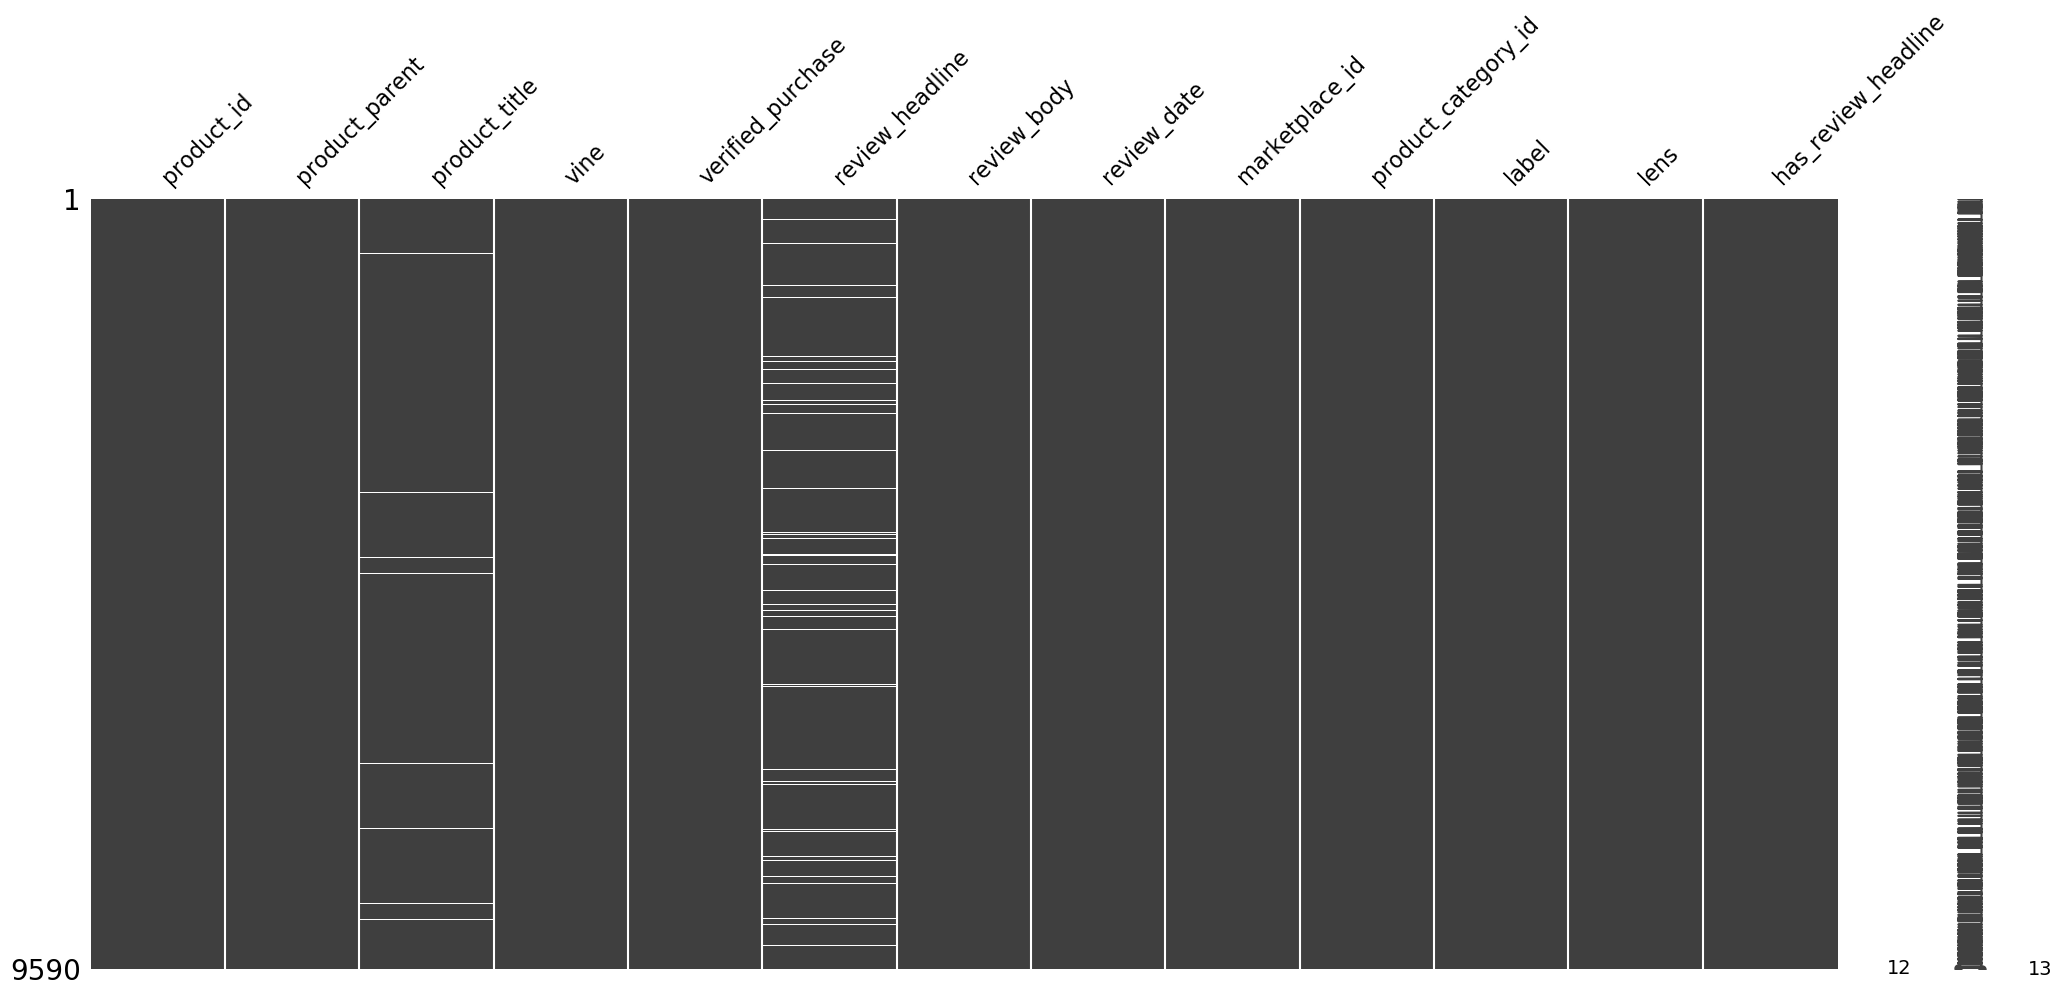

In [52]:
import missingno as mso

mso.matrix(df)
plt.show()

In [50]:
# df['review_date'] = df['review_date'].apply(pd.to_datetime)

In [254]:
qad_df = df.copy()
delete_columns(qad_df, columns_to_delete=['product_id', 'product_title', 'vine', 'review_headline', 'review_body', 'review_date'])

In [256]:
y = qad_df.pop('label')
X = qad_df

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [354]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [431]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [3, 4, 5, 7],
        'learning_rate': [0.1, 0.01, 0.05],
        'n_estimators': [200, 1500],
        'bootstrap': [False, True],

        }

In [432]:
clf = XGBClassifier(learning_rate=0.002, n_estimators=1000, objective='binary:logistic',
                    silent=True, nthread=-1)

# clf = RandomForestClassifier()

folds = 3
param_comb = 20

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(clf, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=-1, cv=skf.split(X,y), verbose=3, random_state=1001)
random_search.fit(X, y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.1min finished
C:\Users\timod\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:53:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "bootstrap", "max_features", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:53:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000024D54843CC8>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0.002,
                                           max_delta_step=None,...
                   param_distributions={'bootstrap': [False, True],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'learning_rate': [0.1, 0.01, 0.05],
                                 

In [433]:
y_pred = random_search.predict(X_test)

In [434]:
accuracy_score(y_test, y_pred)

0.7642018406854967

In [435]:
test_df = pd.read_csv('test_hidden.csv')
validation_df = pd.read_csv('validation_hidden.csv')

In [436]:
test_df = preprocess(test_df, is_train=False)

In [437]:
validation_df = preprocess(validation_df, is_train=False)

In [438]:
COLUMNS = qad_df.columns.tolist()

In [439]:
test_df = test_df[COLUMNS]

In [440]:
validation_df = validation_df[COLUMNS]

In [441]:
y_pred_test = random_search.predict(test_df)

In [442]:
y_pred_val = random_search.predict(validation_df)

In [443]:
y_pred_test = y_pred_test.astype(str)
y_pred_val = y_pred_val.astype(str)

In [444]:
np.savetxt("quick_and_dirty_test2.txt", y_pred_test, delimiter=",", fmt='%s')
np.savetxt("quick_and_dirty_val2.txt", y_pred_val, delimiter=",", fmt='%s')